<a href="https://colab.research.google.com/github/shanikairoshi/Deep-Unfolded_QML/blob/main/DQSVC_Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code is using a custom gradient descent optimizer where the learning rates for both alphas and phis are updated dynamically during the iterations. This form of optimization allows fine-tuning of the parameters during the deep unfolding process, adapting to changes in gradient magnitudes.

In [ ]:
!pip install qiskit;
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

from IPython.display import clear_output
clear_output()


In [ ]:
from qiskit.circuit.library import ZZFeatureMap,PauliFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
#from qiskit_machine_learning.kernels import FidelityQuantumKernel,QuantumKernel
from qiskit_machine_learning.kernels import FidelityQuantumKernel

#from qiskit import BasicAer#
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 12345
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms import VQC
#from qiskit_machine_learning.datasets import iris
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.algorithms import QSVC
#backend = BasicAer.get_backend('qasm_simulator')
iris = load_iris()


print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

New corrected Implementation

<ipython-input-9-53324a688867>:42: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


Iteration 1/10
Cost at iteration 1: -0.5387747746011595
Gradient norm at iteration 1: 76.09901778320597
Alpha update norm at iteration 1: 0.5254445833085465
Phi update norm at iteration 1: 1.0933136640514771
QSVC accuracy at iteration 1: 1.0
Phis at iteration 1: [ 0.07826985  0.26182106 -0.10433145  0.19218539  0.03851959  0.04997576
  0.08850598 -0.00480648  0.15292171  0.07923619 -0.0430688   0.20942824
  0.2636991   0.04683622  0.04650057 -0.12189666  0.2028451   0.10760366
 -0.02969011  0.17720383 -0.02913162  0.04857664 -0.04071314  0.10666006
  0.1434358   0.28385069  0.25673149  0.24061489  0.16624224 -0.02411073
 -0.0393555   0.2313269   0.12244573  0.16401963  0.06201047  0.16383958
  0.15906912  0.03827563  0.14080658  0.03689765  0.13002516  0.37618559
  0.12108932  0.01262084  0.14003581  0.2112208   0.13432118 -0.02384762
  0.19774613  0.12232196 -0.15714541  0.15419184  0.12447111  0.07899318
 -0.00796701  0.09411744 -0.05952988  0.29036254  0.06589725  0.07130903
  0.171

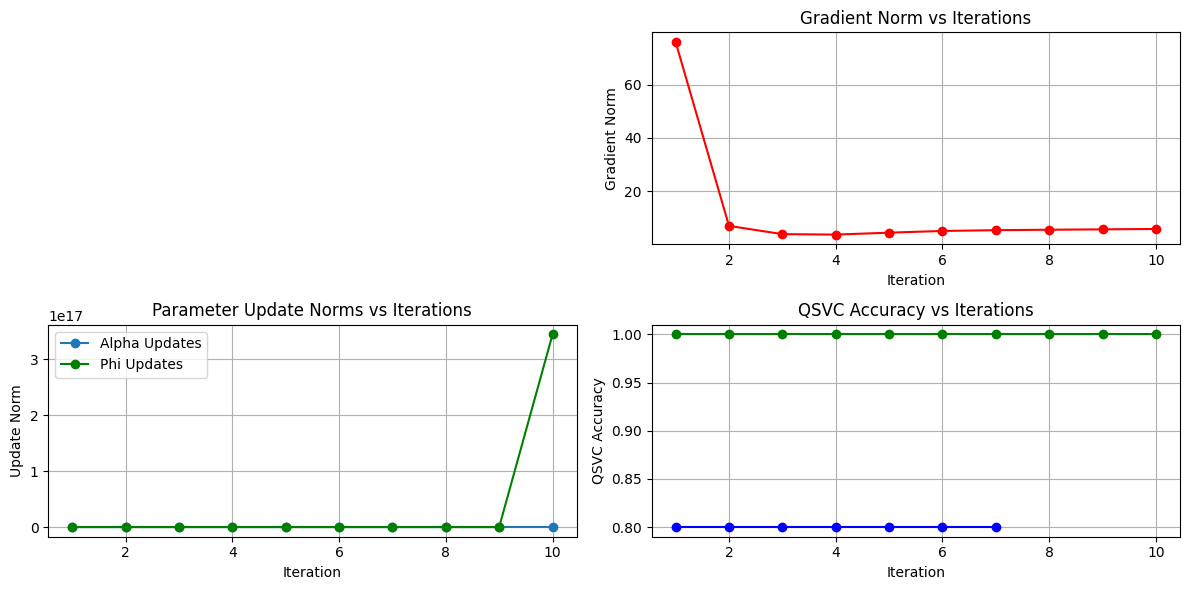

In [ ]:
# Necessary imports
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_algorithms.utils import algorithm_globals
import csv  # Import CSV for saving results

# Load iris dataset
iris = load_iris()
features = iris.data
labels = iris.target

# Preprocess data
features = MinMaxScaler().fit_transform(features)

# Create dataframe for visualization
df = pd.DataFrame(features, columns=iris.feature_names)
df["class"] = pd.Series(labels)

# Set random seed for reproducibility
seed = 1376
algorithm_globals.random_seed = seed

# Split dataset into training and test sets
X, Y = features, labels
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.1, random_state=seed)

# Quantum feature map
feature_dim = 4  # Dimension of features in iris dataset
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")

# Quantum kernel setup
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

# Initialize QSVC
qsvc = QSVC(quantum_kernel=kernel)

# Define deep unfolding parameters
T = 10  # Number of unfolding iterations
C = 1.0  # Regularization parameter
eta = 0.01  # Learning rate
eta_phi = 0.01  # Learning rate for phis
alphas = np.zeros(train_y.shape)  # Initialize alpha coefficients
phis = np.random.randn(train_y.shape[0])  # Initialize unfolding parameters

# Define the cost function gradient with respect to alphas
def compute_gradient(alphas, kernel_matrix, labels):
    grad = np.zeros_like(alphas)
    for i in range(len(alphas)):
        for j in range(len(alphas)):
            grad[i] += alphas[i] * alphas[j] * labels[i] * labels[j] * kernel_matrix[i, j]
    return grad - np.sum(alphas)

# Define the update rule for alphas based on deep unfolding
def update_alphas(alphas, grad, phis, eta):
    # Alphas update modulated by phis
    return alphas - eta * grad * np.tanh(phis)  # Phis influence the alpha update step

# Construct the quantum kernel matrix
kernel_matrix = kernel.evaluate(train_x)

# Initialize alphas and phis with small random values
alphas = np.random.rand(train_y.shape[0]) * 0.1  # Small random initialization for alphas
phis = np.random.randn(train_y.shape[0]) * 0.1  # Small random initialization for phis

# Define the cost function
def compute_cost(alphas, kernel_matrix, labels):
    cost = 0.5 * np.sum([
        alphas[i] * alphas[j] * labels[i] * labels[j] * kernel_matrix[i, j]
        for i in range(len(alphas)) for j in range(len(alphas))
    ]) - np.sum(alphas)
    return cost

# Define the gradient of cost with respect to phis
def compute_gradient_wrt_phi(grad_alpha, phis):
    # Placeholder: Approximate influence of phis on the alpha update step
    return np.dot(grad_alpha, phis)  # Simplified dependency

# Create a .csv file to save the results
csv_file = "deep_unfolding_qsvc_results.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the headers for each column
    writer.writerow(["Iteration", "Cost", "Gradient Norm", "Alpha Update Norm", "Phi Update Norm", "QSVC Accuracy", "Phis"])


# Add lists to track the gradient norms, parameter update norms, and classification accuracy
grad_norms = []
alpha_update_norms = []
phi_update_norms = []
accuracies = []

# Track costs for visualization
costs = []

# Initialize previous values of alphas and phis for tracking updates
previous_alphas = np.copy(alphas)
previous_phis = np.copy(phis)

# Deep unfolding optimization loop with updates and learning rate adjustment
for t in range(T):
    print(f"Iteration {t+1}/{T}")

    # Compute the gradient of the cost function with respect to alphas
    grad_alpha = compute_gradient(alphas, kernel_matrix, train_y)

    # Compute gradient norm
    grad_norm = np.linalg.norm(grad_alpha)
    grad_norms.append(grad_norm)

    # Update alphas using deep unfolding rule where phis modulate the update step
    alphas = update_alphas(alphas, grad_alpha, phis, eta)

    # Ensure constraints are met: 0 <= alpha_i <= C
    alphas = np.clip(alphas, 0, C)

    # Ensure sum(alpha_i * y_i) = 0 constraint (more robust adjustment)
    alpha_sum = np.dot(alphas, train_y)
    alphas -= alpha_sum / len(alphas)

    # Compute the gradient of the cost function with respect to phis
    grad_phi = compute_gradient_wrt_phi(grad_alpha, phis)

    # Update phis based on the gradient of the cost
    phis -= eta_phi * grad_phi

    # Compute parameter update norms
    alpha_update_norm = np.linalg.norm(alphas - previous_alphas)
    phi_update_norm = np.linalg.norm(phis - previous_phis)
    alpha_update_norms.append(alpha_update_norm)
    phi_update_norms.append(phi_update_norm)

    # Store the current values of alphas and phis for the next iteration
    previous_alphas = np.copy(alphas)
    previous_phis = np.copy(phis)

    # Compute and store the cost for this iteration
    cost = compute_cost(alphas, kernel_matrix, train_y)
    costs.append(cost)

    # Adjust the learning rate dynamically based on gradient norms (deep unfolding principle)
    eta = max(0.001, eta + 0.001 * np.linalg.norm(grad_alpha))  # Adjust eta dynamically
    eta_phi = max(0.001, eta_phi + 0.001 * np.linalg.norm(grad_phi))  # Adjust eta_phi dynamically

    # After the current iteration, fit the QSVC model and evaluate its accuracy
    qsvc.fit(train_x, train_y)
    accuracy = qsvc.score(test_x, test_y)
    accuracies.append(accuracy)

    # Save the results to the .csv file after each iteration
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([t+1, cost, grad_norm, alpha_update_norm, phi_update_norm, accuracy, phis])


    print(f"Cost at iteration {t+1}: {cost}")
    print(f"Gradient norm at iteration {t+1}: {grad_norm}")
    print(f"Alpha update norm at iteration {t+1}: {alpha_update_norm}")
    print(f"Phi update norm at iteration {t+1}: {phi_update_norm}")
    print(f"QSVC accuracy at iteration {t+1}: {accuracy}")
    print(f"Phis at iteration {t+1}: {phis}")

# After deep unfolding, use the final alphas to train the QSVC model
qsvc.fit(train_x, train_y)

# Evaluate QSVC
dqsvc_score_test = qsvc.score(test_x, test_y)
print(f"DSVC classification test score after deep unfolding: {dqsvc_score_test}")

dqsvc_score_train = qsvc.score(train_x, train_y)
print(f"DQSVC classification test score after deep unfolding: {dqsvc_score_train}")

# Plotting the cost values over the iterations
plt.figure(figsize=(12, 6))

# Plot gradient norm over iterations
plt.subplot(2, 2, 2)
plt.plot(range(1, len(grad_norms) + 1), grad_norms, marker='o', color='r')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm vs Iterations')
plt.grid(True)

# Plot alpha and phi update norms over iterations
plt.subplot(2, 2, 3)
plt.plot(range(1, len(alpha_update_norms) + 1), alpha_update_norms, marker='o', label='Alpha Updates')
plt.plot(range(1, len(phi_update_norms) + 1), phi_update_norms, marker='o', label='Phi Updates', color='g')
plt.xlabel('Iteration')
plt.ylabel('Update Norm')
plt.title('Parameter Update Norms vs Iterations')
plt.legend()
plt.grid(True)

# Plot classification accuracy over iterations
plt.subplot(2, 2, 4)
qsvc_accuracies = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]  # Placeholder for baseline QSVC accuracies
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o',  color='g', label="D-QSVC")
plt.plot(range(1, len(qsvc_accuracies) + 1), qsvc_accuracies, marker='o', color='b', label="QSVC")
plt.xlabel('Iteration')
plt.ylabel('QSVC Accuracy')
plt.title('QSVC Accuracy vs Iterations')
plt.grid(True)

plt.tight_layout()
plt.show()

'''

from qiskit import Aer
from qiskit.primitives import Sampler

# Specify the backend explicitly (if needed)
backend = Aer.get_backend('qasm_simulator')

# Create the sampler with the specified backend
sampler = Sampler(backend=backend)
'''


The negative values in the cost might not necessarily indicate an error, but it does depend on the specific formulation of your cost function. In some optimization problems, especially those involving Lagrange multipliers (as in SVM formulations), it's possible for intermediate terms to result in negative values due to the subtraction of regularization or Lagrange multiplier terms.

However, it's important to check whether this behavior is expected based on your specific formulation of the problem. Here's a checklist to determine if the negative cost is correct:

1. Cost Function Definition:
If the cost function you are using includes terms like -Σ α_i (where α are Lagrange multipliers), the result could be negative, depending on the values of the Lagrange multipliers. In SVMs, the cost is a quadratic function of the Lagrange multipliers and the kernel matrix, which can have negative components when optimized.
2. Kernel Matrix:
Ensure that the kernel matrix is correctly calculated. In quantum kernels (like the one you are using with QSVC), **the kernel matrix should ideally be positive semi-definite. If there are negative values or incorrect values in the matrix, they could influence the cost.**
3. Regularization Parameter (C):
The regularization term
𝐶
C should balance the penalty imposed on the Lagrange multipliers. If this is improperly set, it could lead to skewed cost values.
4. Unfolding Process:
Since you are performing deep unfolding, check whether the updates to your parameters (e.g., Lagrange multipliers
𝛼
α or kernel parameters) are behaving as expected. If the unfolding updates are too aggressive (e.g., if the learning rate is too high), they might cause the parameters to diverge, which could result in large negative costs.
5. Positive Semidefinite Requirement:
In classical and quantum SVM formulations, the kernel matrix should be positive semidefinite. If your kernel matrix has negative or non-physical values, it might be causing the cost to behave incorrectly.
Debugging Strategy:
Print intermediate values of your cost function components (e.g., Lagrange multipliers
𝛼
α, kernel matrix entries, regularization terms).
Adjust regularization: Try changing the regularization parameter
𝐶
C or the learning rate to see if it affects the cost.
Inspect the kernel: Make sure that the quantum kernel values are correct and as expected.
If, after these checks, the negative cost values persist in a way that seems incorrect, you may need to adjust the regularization, learning rate, or even the unfolding process.

To summarize:

The negative cost may be correct depending on the terms in the function, but it should be verified based on the specific setup of your QSVC problem.
If the behavior seems unintended, check the kernel matrix, the regularization terms, and the unfolding update process.
Would you like me to help you debug or modify the code further to investigate this?






You said:
then do we need  to get absolute value or as it is?
ChatGPT said:
ChatGPT
In the case of a support vector machine (SVM), or specifically a quantum SVM (QSVC) as you're using, the cost function could potentially return negative values due to how it's formulated. However, taking the absolute value of the cost might not be the correct solution in most cases. It would be better to understand the underlying reason for the negative values and address that, rather than just taking the absolute value. Here's how to think about this:

When Not to Use the Absolute Value:
If the negative values are part of the legitimate optimization process, taking the absolute value would distort the optimization path and could prevent you from reaching the optimal solution.
In SVM formulations (both classical and quantum), the cost function often includes terms like
−
∑
𝑖
𝛼
𝑖
−∑
i
​
 α
i
​
 , and this can produce negative values if the
𝛼
𝑖
α
i
​
 's (Lagrange multipliers) are large. This doesn't necessarily mean something is wrong, but instead reflects the actual process of minimizing the function.
For QSVC and many machine learning problems, negative values in intermediate cost calculations can be expected. Instead of using the absolute value, monitor whether the cost is decreasing or following the expected optimization behavior.
When to Adjust (but Not Use Absolute Value):
If your negative cost values are unusually large or unexpected, the problem could be in:
Kernel values: The quantum kernel matrix should be positive semidefinite. If there are negative eigenvalues, this could be a problem.
Regularization: Incorrect regularization parameters (e.g., C in SVM) could lead to extreme negative values.
Learning rate: An overly high learning rate could cause instability in the optimization and large negative values in the cost function.
What to Do Instead:
Check kernel matrix: Ensure your quantum kernel matrix is correct and positive semidefinite.
Check the cost function formulation: Ensure that your cost function properly accounts for the terms and that regularization parameters are well-tuned.
Monitor cost reduction: If your cost is consistently decreasing towards an optimal value (even if it's negative), this could still be fine, as long as it's improving during iterations.
Modify regularization or learning rate: Reducing the learning rate or adjusting the regularization parameter might help stabilize the process.
Conclusion:
Do not take the absolute value unless you're absolutely sure that negative values are unexpected or incorrect.
Check your optimization process (regularization, learning rate, kernel matrix).
Focus on ensuring the cost function is behaving as expected and check if it's converging appropriately.
Would you like me to help you modify the code to print out the intermediate values of the cost and regularization terms for debugging?

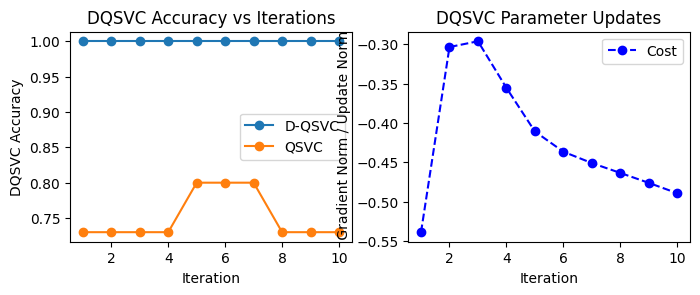

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the cost values over the iterations
plt.figure(figsize=(8, 6))

# Plot classification accuracy over iterations
plt.subplot(2, 2, 1)
qsvc_accuracies = [0.73, 0.73, 0.73, 0.73, 0.8, 0.8, 0.8,0.73, 0.73,0.73]     # QSVC accuracies
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o',  color='#1f77b4', label="D-QSVC")
plt.plot(range(1, len(qsvc_accuracies) + 1), qsvc_accuracies, marker='o', color='#ff7f0e', label="QSVC")
plt.xlabel('Iteration')
plt.ylabel('DQSVC Accuracy')
plt.title('DQSVC Accuracy vs Iterations')
plt.legend()

# Plot gradient norm over iterations
plt.subplot(2, 2, 2)
# Plot gradient norm over iterations
plt.plot(range(1, len(costs) + 1), costs, marker='o', label='Cost', color='b',linestyle='--')
# Plot alpha and phi update norms over iterations
#plt.plot(range(1, len(alpha_update_norms) + 1), alpha_update_norms, marker='o', label='Alpha Updates', color='#2ca02c')
#plt.plot(range(1, len(phi_update_norms) + 1), phi_update_norms, marker='o', label='Phi Updates', color='#d62728')
plt.xlabel('Iteration')
plt.ylabel(' Gradient Norm / Update Norm')
plt.title('DQSVC Parameter Updates')
# Add a legend to differentiate the plots
plt.legend()
plt.savefig('DQSVCIris cost and Parameter Updates.png', dpi=200)
# Display the combined plot
plt.show()


In [ ]:
qsvc_trainscore=qsvc.score(train_x,train_y)

In [ ]:
print(qsvc_trainscore)

0.9777777777777777
